# Classify field photos as fog or no fog.

Author: Autumn Nguyen

Version: July 2023

In [1]:
# ! pip install scikit-image
# ! pip install plotly==5.15.0

In [1]:
import os
import glob as glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from skimage.io import imread
from skimage.transform import resize, rescale
import plotly.express as px

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Prepare training data

In [6]:
input_dir = '/Users/autumn_yngoc/Downloads/Marine Fog/Mt Dallas Jul-Sep 2022 photos'
categories = ['no_fog', 'fog'] # no_fog as 0, and fog as 1

img_list = [] 
rescaled_list = []
data_list = [] # feature array
label_list = [] # target array

# Loop through the no_fog and fog folders
for category_idx, category in enumerate(categories):
    # Find all the image files
    files = glob.glob(os.path.join(input_dir, category, '*.JPG'))
    print(len(files))
    for file in files:
        # Read each image file into a 3D array of numbers
        img = imread(file)
        img_list.append(img)
        # img = resize(img, (15, 15))
        # Rescale each image into 5% resolution to reduce runtime
        rescaled_img = rescale(img, 0.05, channel_axis = 2)
        rescaled_list.append(rescaled_img)
        # flatten the 3D numpy arrays into a 1D array, and append it to the feature list
        data_list.append(rescaled_img.flatten()) 
        # Append the category index (0 for 'no_fog', and 1 for 'fog') to the target list
        label_list.append(category_idx)


41


In [7]:
# Convert the lists to arrays
data = np.asarray(data_list)
labels = np.asarray(label_list)

In [9]:
# Split 70/30 train/test set
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, shuffle=True, stratify=labels, random_state=13)
y_test

array([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0])

## Train a model

In [33]:
classifier = SVC(probability=True)

In [34]:
parameters = [{'gamma': [0.01, 0.001, 0.0001, 0.00001], 'C': [1, 10, 100, 1000, 10000]}]

In [35]:
# GridSearchCV will perform an exhaustive search over all possible combinations of hyperparameters to find the optimal values
grid_search = GridSearchCV(classifier, parameters)

grid_search.fit(x_train, y_train)

GridSearchCV(estimator=SVC(probability=True),
             param_grid=[{'C': [1, 10, 100, 1000, 10000],
                          'gamma': [0.01, 0.001, 0.0001, 1e-05]}])

In [41]:
print(grid_search.best_score_)
best_estimator = grid_search.best_estimator_
best_estimator

0.8400000000000001


SVC(C=1000, gamma=0.0001, probability=True)

In [42]:
y_train_pred = best_estimator.predict(x_train)
y_test_pred = best_estimator.predict(x_test)

train_score = accuracy_score(y_train_pred, y_train)
test_score = accuracy_score(y_test_pred, y_test)

print('{}% of samples were correctly classified'.format(str(train_score * 100)))
print('{}% of samples were correctly classified'.format(str(test_score * 100)))

tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_test_pred).ravel()
print("Test: ", tn_test, fp_test, fn_test, tp_test)

100.0% of samples were correctly classified
81.81818181818183% of samples were correctly classified
Test:  7 2 2 11


## Look closely at some of the predictions
A note about probability score: in binary classification, a sample may be labeled by predict as belonging to the positive class even if the output of predict_proba is less than 0.5; and similarly, it could be labeled as negative even if the output of predict_proba is more than 0.5 (https://scikit-learn.org/stable/modules/svm.html#scores-probabilities)

Probability being no_fog = 77.55386625840146%
Probability being fog = 22.446133741598555%
The predicted image is : no_fog


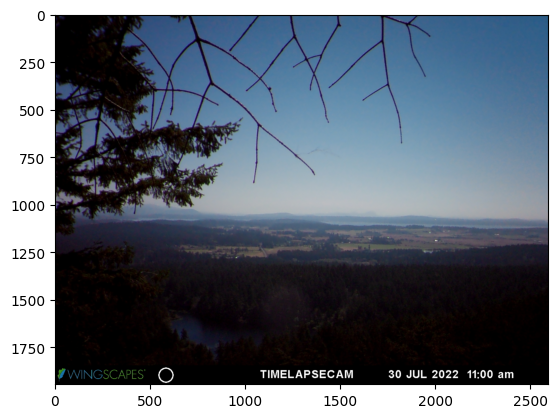

In [58]:
plt.imshow(img_list[0])
probability = best_estimator.predict_proba([data[0]])
for ind,val in enumerate(categories):
    print(f'Probability being {val} = {probability[0][ind]*100}%')
print("The predicted image is : "+categories[best_estimator.predict([data[0]])[0]])

Probability being no_fog = 77.5499314968237%
Probability being fog = 22.45006850317631%
The predicted image is : no_fog


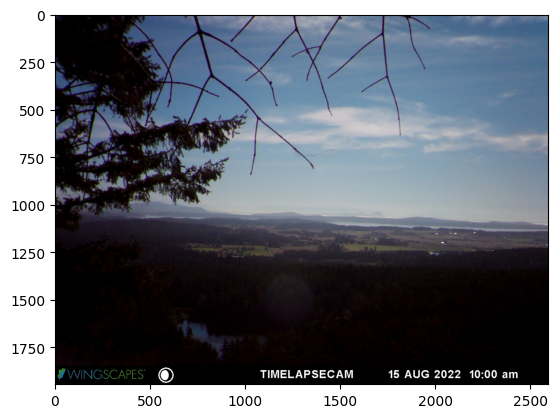

In [57]:
plt.imshow(img_list[1])
probability = best_estimator.predict_proba([data[1]])
for ind,val in enumerate(categories):
    print(f'Probability being {val} = {probability[0][ind]*100}%')
print("The predicted image is : "+categories[best_estimator.predict([data[1]])[0]])

Probability being no_fog = 77.55323958689611%
Probability being fog = 22.44676041310389%
The predicted image is : no_fog


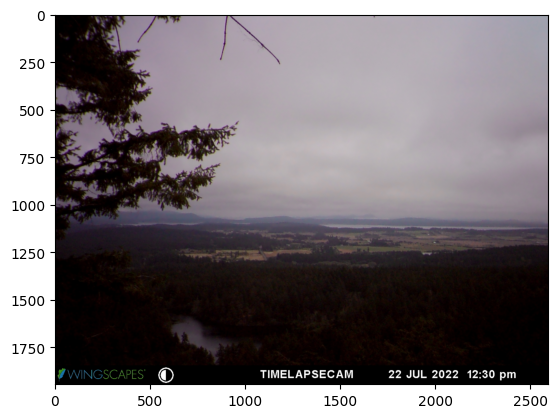

In [56]:
plt.imshow(img_list[30])
probability = best_estimator.predict_proba([data[30]])
for ind,val in enumerate(categories):
    print(f'Probability being {val} = {probability[0][ind]*100}%')
print("The predicted image is : "+categories[best_estimator.predict([data[30]])[0]])

Probability being no_fog = 19.974391573530117%
Probability being fog = 80.02560842646989%
The predicted image is : fog


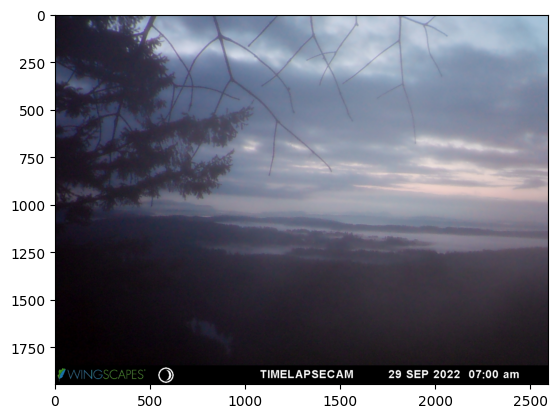

In [54]:
plt.imshow(img_list[-40])
probability = best_estimator.predict_proba([data[-40]])
for ind,val in enumerate(categories):
    print(f'Probability being {val} = {probability[0][ind]*100}%')
print("The predicted image is : "+categories[best_estimator.predict([data[-40]])[0]])

Probability being no_fog = 3.224809262745401%
Probability being fog = 96.77519073725458%
The predicted image is : fog


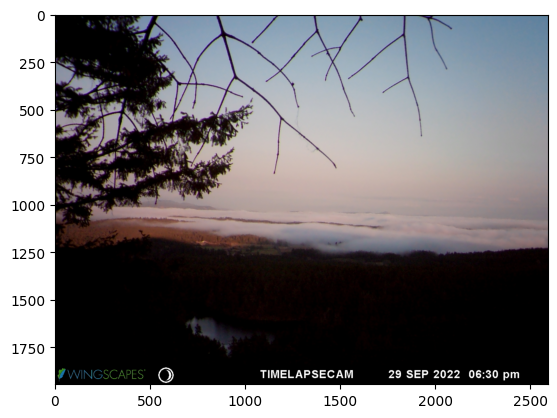

In [48]:
plt.imshow(img_list[-1])
probability = best_estimator.predict_proba([data[-1]])
for ind,val in enumerate(categories):
    print(f'Probability being {val} = {probability[0][ind]*100}%')
print("The predicted image is : "+categories[best_estimator.predict([data[-1]])[0]])

In [59]:
# Save the best model by pickling it so that we don't need ro do the training process again after restarting the notebook
pickle.dump(best_estimator, open('./model.p', 'wb'))

## Use the model to predict all photos
Including the photos used for training and testing earlier, and the remaining photos in the folder to be classifed.

In [60]:
import PIL.Image

### Prepare all data for classification

In [61]:
input_dir = '/Users/autumn_yngoc/Downloads/Marine Fog/Mt Dallas Jul-Sep 2022 photos/photos' # Where I store the photos on my local computer
files = glob.glob(os.path.join(input_dir, '*.JPG'))
len(files)

2043

In [62]:
# Initialize lists to create an output dataframe afterwards
x = []
names = []
paths = []
times = []

for file in files:
    paths.append(file) # file path
    names.append(file.split('/')[-1]) # file name

    # Get the array of numbers representation of the image
    img = imread(file)

    # Get the creation time from the metadata of the iamge file
    time_str = PIL.Image.open(file)._getexif()[36867]
    time = pd.to_datetime(time_str, format='%Y:%m:%d %H:%M:%S')
    times.append(time)
    
    rescaled_img = rescale(img, 0.05, channel_axis = 2).flatten()
    # Append the rescaled and flattened image array to a list 
    x.append(rescaled_img)    

In [64]:
# Convert the list to a numpy feature array
X = np.asarray(x)

### Run the model on the data
Use the model to classify all images in a directory. Then output a pandas dataframe with image file name corresponding with the predicted no_fog/fog label

In [65]:
# Load the best SVC model found from Grid Search that we pickled earlier
pickled_model = pickle.load(open('./model.p', 'rb')) 

# Get the predicted target array
y_pred = pickled_model.predict(X)

dict = {"Time": times, "Image file" : names, "File path": paths, "Predicted label" : y_pred}
df = pd.DataFrame(dict)

In [66]:
df[df['Predicted label'] == 1].shape[0]/df.shape[0] # fog frequency

0.3088595203132648

In [67]:
# Sort the dataframe chronologically
df = df.sort_values(by=['Time'])

In [68]:
df

,Time,Image file,File path,Predicted label
722,2022-07-19 12:07:23,WSCT2405.JPG,/Users/autumn_yngoc/Downloads/Marine Fog/Mt Da...,1
594,2022-07-19 12:37:23,WSCT2406.JPG,/Users/autumn_yngoc/Downloads/Marine Fog/Mt Da...,0
563,2022-07-19 13:07:23,WSCT2407.JPG,/Users/autumn_yngoc/Downloads/Marine Fog/Mt Da...,0
1326,2022-07-19 13:37:23,WSCT2408.JPG,/Users/autumn_yngoc/Downloads/Marine Fog/Mt Da...,0
1358,2022-07-19 14:07:23,WSCT2409.JPG,/Users/autumn_yngoc/Downloads/Marine Fog/Mt Da...,0
...,...,...,...,...
760,2022-09-30 16:30:01,WSCT4458.JPG,/Users/autumn_yngoc/Downloads/Marine Fog/Mt Da...,0
646,2022-09-30 17:00:01,WSCT4459.JPG,/Users/autumn_yngoc/Downloads/Marine Fog/Mt Da...,0
778,2022-09-30 17:30:01,WSCT4460.JPG,/Users/autumn_yngoc/Downloads/Marine Fog/Mt Da...,1
891,2022-09-30 18:00:01,WSCT4461.JPG,/Users/autumn_yngoc/Downloads/Marine Fog/Mt Da...,1


In [69]:
df.to_csv('MtDallas_JulSep2022_PredictedFog_SVC.csv')

In [70]:
concise_df = df[['Time', 'Predicted label']].reset_index(drop=True)

In [71]:
concise_df

,Time,Predicted label
0,2022-07-19 12:07:23,1
1,2022-07-19 12:37:23,0
2,2022-07-19 13:07:23,0
3,2022-07-19 13:37:23,0
4,2022-07-19 14:07:23,0
...,...,...
2038,2022-09-30 16:30:01,0
2039,2022-09-30 17:00:01,0
2040,2022-09-30 17:30:01,1
2041,2022-09-30 18:00:01,1


In [73]:
concise_df.to_csv('MtDallas_predicted_time_df.csv')